<a href="https://colab.research.google.com/github/mahimscit/DO180-apps/blob/master/14thDec_TimeSeries_Dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<hr>

# **Introduction**

## **Alright everyone, what's up!👋Dev here, and guess what? We've got a super cool time series workshop lined up for today!🏗️ We'll be digging into some awesome data and uncovering some mind-blowing insights. 💹 I'm pumped for this, and I hope you are too! Just give everyone a few minutes to join in, and we'll kick things off at 10:10 AM sharp. See you there!😃**

<hr>

# **Agenda**

  **Build a model to forecast the demand (Passengers Traffic) in Airplanes. The data is classified in date/time and the passengers travelling per month**

<hr>

# **Components to Time-Series**

**Time Series: This method is used to analyze data points collected over time, by understanding the patterns and trends in time series data, analysts can make informed predictions and decisions.**

* **Components of Time Series**
  * **`Trend`: A trend in a time series is a long-term upward or downward movement in the data. It's a fundamental component that often influences the overall pattern of the series.**
  * **`Seasonality`: Seasonality is a recurring pattern in a time series that repeats over a fixed period. This periodicity can be daily, weekly, monthly, quarterly, or yearly.**
  * **Cyclic Pattern:In time series, these are some irregular flucations**
  * **Irregular (Residual) Components: Some unusual Stuff happeneing**

**Dataset Link: https://drive.google.com/file/d/1U2eHZDxJOXZr8MLW1vLaCluOhtC4T9iE/view?usp=drive_link**

# **Step 1 - Requirement Phase (Libraries)**

**Configuration Libraries**

In [ ]:
import warnings
warnings.filterwarnings("ignore")

**Classical Libraries**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('dark_background')

**Machine Learning Libraries**

In [ ]:
!pip install pmdarima
import itertools
from sklearn.metrics import *
# from pmdarima.arima import autoarima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

<hr>

# **Step 2 - Data Loading Phase (Data Ingestion)**

### **Data Loading**

In [ ]:
df = pd.read_csv("/content/AirPassengers.csv")

### **Data Inspection Phase**

In [ ]:
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


**This data is sequential**

### **Shape Inspection**

In [ ]:
a = df.shape
print(f"Rows: {a[0]} & Columns: {a[1]}")

Rows: 144 & Columns: 2


### **Data Information Phase**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


**Insights**
  * **The column month should be in date-time format**

In [ ]:
df["Month"] = pd.to_datetime(df["Month"], infer_datetime_format = True)

In [ ]:
df.head()

,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


### **Set index as month**

In [ ]:
df = df.set_index("Month")

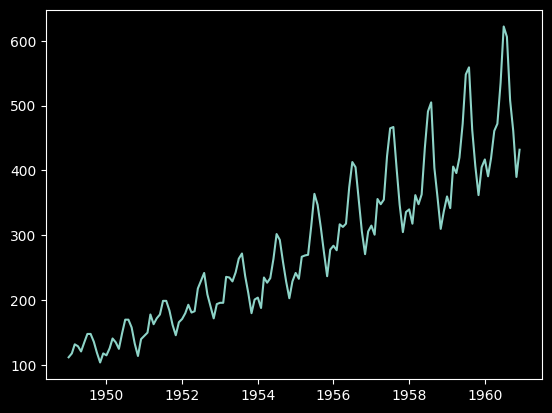

In [ ]:
plt.plot(df)

In [ ]:
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


### **Visualize**

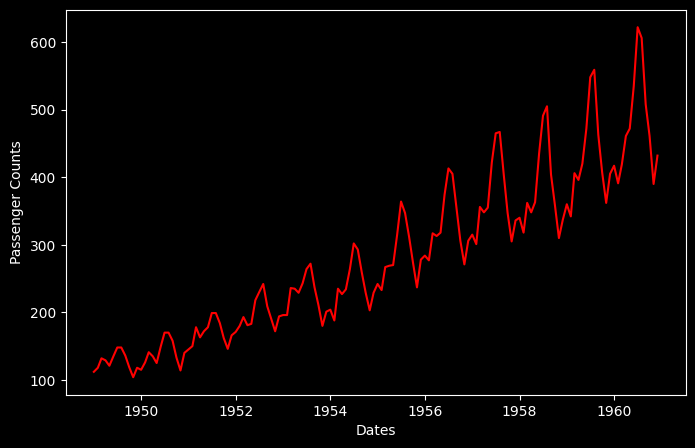

In [ ]:
plt.figure(figsize = (8, 5))
plt.plot(df, color = "red")
plt.xlabel("Dates")
plt.ylabel("Passenger Counts")
plt.show()

* **The data shows a increasing trend, moreover we can also say that this is a seasonal upward trend**

* **There is huge chance, that the data might be un-stationary, by simply visualizing, since we can observe that the mean and the variance are not constant**

# **Step 3 - Check for stationarity**

  * **We need to ensure that the mean and the variance is constant**

### **Rolling Statistics**

In [ ]:
# Rolling Mean
rolling_mean = df.rolling(window = 12).mean()

# Rolling Std Dev (1 year timeframe)
rolling_std = df.rolling(window = 12).std()

#### **Visualizing the rolling stats**

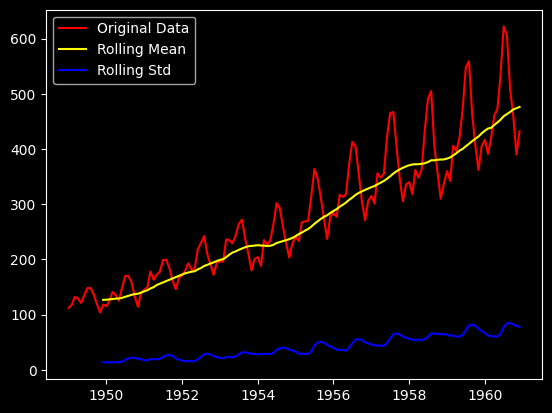

In [ ]:
original_data = plt.plot(df, color = "red", label = "Original Data")
mean_data = plt.plot(rolling_mean, color = "yellow", label = "Rolling Mean")
std_data = plt.plot(rolling_std, color = "blue", label = "Rolling Std")
plt.legend()
plt.show()

**The mean is fairly increasing with respect to time, variance is not so stable**

### **ADFuller - Augmented Dickey Fuller Test**
  * **This is a tool for checking stationarity statistically**
  * **What's the condition of stationarity**
    * **If the p-value is low (< 0.05) -> Stationary**
    * **If the p-value is high (> 0.05) -> Non Stationary**

In [ ]:
results = adfuller(df)

In [ ]:
print(f"P-value: {results[1]}")

P-value: 0.991880243437641


In [ ]:
if results[1] > 0.05:
  print("Non Stationary")
else:
  print("Stationary")

Non Stationary


### **Helper Function**

In [ ]:
def helper(data):
  # Rolling Mean
  rolling_mean = data.rolling(window = 12).mean()
  # Rolling Std Dev (1 year timeframe)
  rolling_std = data.rolling(window = 12).std()

  original_data = plt.plot(data, color = "red", label = "Original Data")
  mean_data = plt.plot(rolling_mean, color = "yellow", label = "Rolling Mean")
  std_data = plt.plot(rolling_std, color = "blue", label = "Rolling Std")
  plt.legend()
  plt.show()

  results = adfuller(data)
  if results[1] > 0.05:
    print(f"Non Stationary, P-value: {results[1]}")
  else:
    print(f"Stationary, P-value: {results[1]}")

# **Step 4 - Achieve the stationary**
  * **Transformation: We can scale the values, this helps you to make your variance constant**
  * **Differencing / Shift**

### **Transformation**
  * **Normalize Data: To make value more comparable**
  * **Stablize the variance**
  * **More LInear Relationship**

### **Log Transformation**

In [ ]:
df_log = np.log(df)

#### **Check for the stationarity**

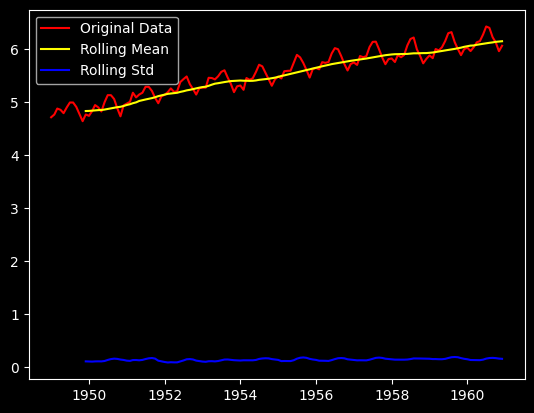

Non Stationary, P-value: 0.4223667747703874


In [ ]:
helper(df_log)

**Transformation adjusts data for consistent variance and stationarity to refine insights and analytical accuracy.**

### **Differencing**
  * **It is the technique of substracting the previous value with the current values**
  * **`y't = yt - y(t-1)`**

#### **First Order Differencing**

In [ ]:
df_log_diff1 = df_log.diff().dropna()

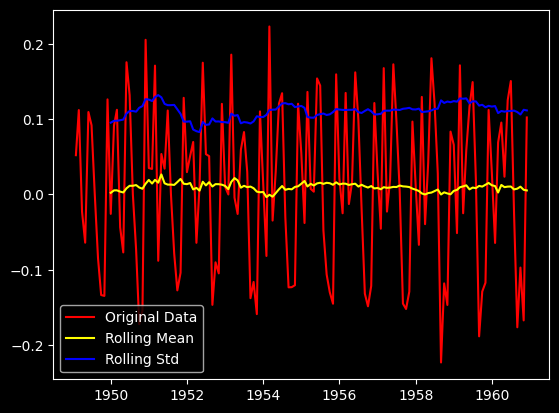

Non Stationary, P-value: 0.07112054815086184


In [ ]:
helper(df_log_diff1)

#### **Second Order Differencing**

In [ ]:
df_log_diff2 = df_log.diff().diff().dropna()

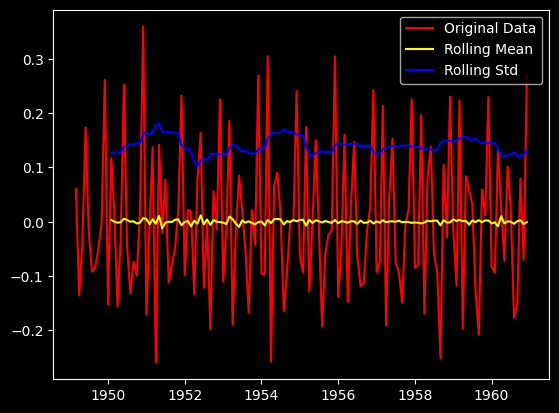

Stationary, P-value: 7.419304549376186e-13


In [ ]:
helper(df_log_diff2)

* **Since the p-value is very small in this case, we would go with the first one**

# **Step 5 - Discovering the order of the models**

### **Auto Correlation Function (ACF) and Partial AutoCorrelation Function(PACF)**


#### **Auto Correlation Function (ACF)**
  * **This measure the correlation between a time series (Current) with the previous timestamps**

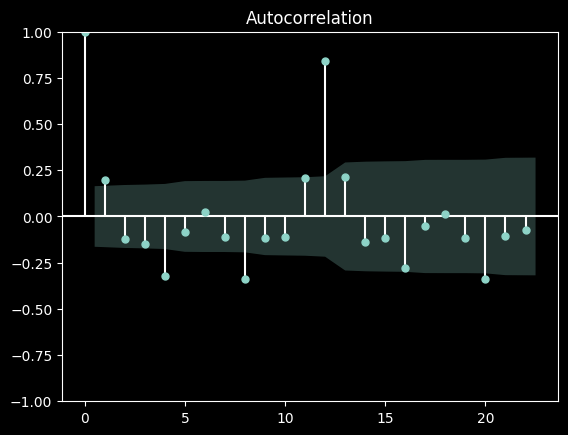

In [ ]:
plot_acf(df_log_diff1)
plt.show()
plt.close()

#### **Partial AutoCorrelation Function(PACF)**

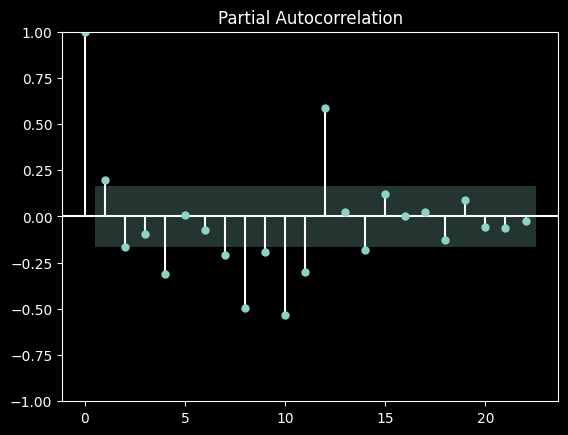

In [ ]:
plot_pacf(df_log_diff1)
plt.show()
plt.close()

* **Assume: Model1 = (4, 0, 1)**
* **Assume: Model2 = (4, 0, 4)**

# **Step 6 - Model Building**

### **Model 1 = ARIMA(4, 0, 4)**

In [ ]:
model = ARIMA(df_log_diff1, order =  (4, 0, 4))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
results = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
errors = sum((results.fittedvalues - df_log_diff1["#Passengers"])**2)

In [ ]:
errors

1.0256999726169713

### **Model 2 = ARIMA(4, 0, 1)**

In [ ]:
model2 = ARIMA(df_log_diff1, order = (4, 0, 1))

results2 = model2.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
errors2 = sum((results2.fittedvalues - df_log_diff1["#Passengers"])**2)

In [ ]:
errors2

1.329709035495222

### **Model 3 - ARIMA(4, 0, 2)**

In [ ]:
model3 = ARIMA(df_log_diff1, order = (4, 0, 2))

results3 = model3.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
errors3 = sum((results3.fittedvalues - df_log_diff1["#Passengers"])**2)

In [ ]:
errors3

1.0871265275024533

# **Step 7 - AutoARIMA**

In [ ]:
!pip install pmdarima

In [ ]:
import pmdarima as pm
from pmdarima.arima import auto_arima
from sklearn.model_selection import train_test_split

**DEMO PART for AUTOARIMA**

In [ ]:
data = pm.datasets.load_wineind()

In [ ]:
train, test = train_test_split(data, train_size = 150)

In [ ]:
arima = auto_arima(train, # data
                   error_action = "ignore", # action that we would take if in case of errors
                   trace = True, # is for the output
                   suppress_warnings = True,
                   seasonal = True,
                   m = 12,
                   maxiter = 5
                   )

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2994.494, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=3055.210, Time=0.20 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=2995.189, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=3478.892, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=2996.493, Time=0.08 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=2996.418, Time=0.06 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=2992.507, Time=0.13 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=2994.469, Time=0.38 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=2994.041, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=2995.105, Time=0.71 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=2993.226, Time=0.47 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept

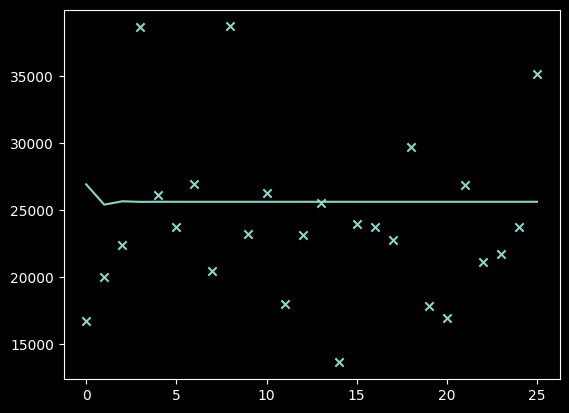

In [ ]:
x = np.arange(test.shape[0])
plt.scatter(x, test, marker = "x")
plt.plot(x, arima.predict(n_periods = test.shape[0]))
plt.show()

In [ ]:
arima_model = auto_arima(
    df_log_diff1, # data
    test = "adf", # test we are considering
    start_p = 0,
    start_q = 0,
    seasonal = True,
    max_p = 13,
    max_q = 13,
    stepwise = True,
    trace = True,
    suppress_warnings = True,
    error_action = "ignore"
)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-231.565, Time=0.30 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-235.386, Time=0.40 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-237.507, Time=0.76 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-232.439, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-241.608, Time=0.77 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-268.893, Time=2.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-237.605, Time=1.00 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-269.575, Time=2.08 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-236.952, Time=0.58 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=-248.753, Time=0.78 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-269.822, Time=1.89 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-262.544, Time=4.75 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=-275.362, Time=2.36 sec


In [ ]:
x = np.arange(60)


In [ ]:
x

In [ ]:
plt.plot(x, arima.predict(n_periods = 60))
plt.show()

In [ ]:
main_model = ARIMA(df_log_diff1, order = (4, 0, 3))

main_results = main_model.fit()

In [ ]:
main_errors = sum((main_results.fittedvalues - df_log_diff1["#Passengers"])**2)

In [ ]:
plt.plot(df_log_diff1, label = "Original Data", color = "red")
plt.plot(main_results.fittedvalues, color = "blue")
plt.title(f"Errors: {main_errors}")

plt.legend()
plt.show()

In [ ]:
pred = main_results.predict(1, 143 + 60)

In [ ]:
plt.plot(df_log_diff1)
plt.plot(pred, color = "yellow")
plt.show()

# **Step 8 - SARIMA**